# Table of Contents
 <p><div class="lev1 toc-item"><a href="#plot-NMI-as-beta-varies" data-toc-modified-id="plot-NMI-as-beta-varies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>plot NMI as beta varies</a></div>

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import modbp
import forceatlas2 as fa2
import seaborn as sbn
# reload(modbp)

In [46]:
n=200
q=3
nblocks=q
pin=(5.0*q)/n
pout=(.50*q)/n
t=time()
prob_mat=np.identity(nblocks)*pin + (np.ones((nblocks,nblocks))-np.identity(nblocks))*pout
print prob_mat
RSBM = modbp.RandomSBMGraph(n=n,comm_prob_mat=prob_mat)
bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=1, transform=False)
bpgc.run()
marg=np.array(bpgc.return_marginals())
color_dict=dict(zip(range(10),sbn.color_palette('Set1',10)))
RSBM.graph.vs['color']=map(lambda x : color_dict[np.argmax(x)],marg)
m= RSBM.m
elist=RSBM.get_edgelist()
elist.sort()
pv=modbp.bp.PairVector(elist)
print("time to construct {:.4f}".format(time()-t))

[[0.075  0.0075 0.0075]
 [0.0075 0.075  0.0075]
 [0.0075 0.0075 0.075 ]]
[66, 66, 68]
time to construct 0.0174


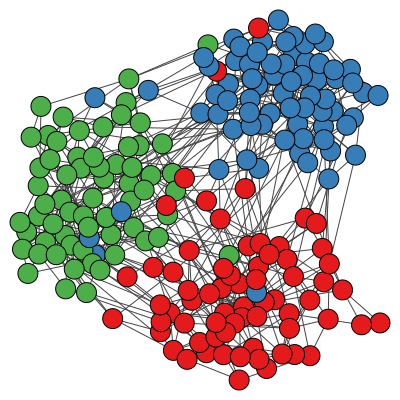

In [47]:
#create forceatlas layout
adj=np.array(RSBM.get_adjacency().data)
pos=fa2.forceatlas2(adj,scalingRatio=10,gravity=1,strongGravityMode=False,edgeWeightInfluence=0)
layout=ig.Layout(pos)
ig.plot(RSBM.graph,layout=layout,inline=True,bbox=[400,400])

# plot NMI as beta varies

In [48]:
betas=np.linspace(.1,2,50)
fin_nmi=[]
for beta in betas:
    #This is where we would want to be able to recall the BP algorithm
    #without having to reconstruct the graph.  Presumably we could use 
    #the state of previous BP as warm initialization
    bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=beta, transform=False)
    bpgc.run()
    marg=np.array(bpgc.return_marginals())
    color_dict={0:"red",1:"blue",2:'green'}
    RSBM.graph.vs['color']=map(lambda x : color_dict[np.argmax(x)],marg)
    cnmi=RSBM.get_AMI_with_blocks(RSBM.graph.vs['color'])
#     print("NMI at beta={:.2f}: {:.3f}".format(beta,cnmi))
    fin_nmi.append(cnmi)

fin_nmi=np.array(fin_nmi)

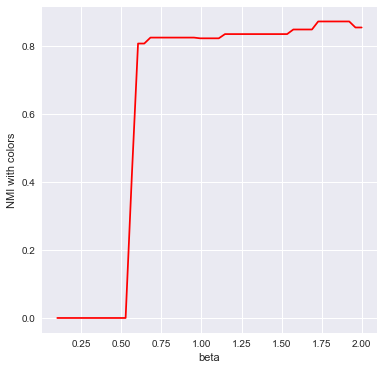

In [49]:
plt.close()
f,a=plt.subplots(1,1,figsize=(6,6))
a.plot(betas,fin_nmi,color='r')
a.set_xlabel('beta')
a.set_ylabel('NMI with colors')
plt.show()